In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '11/05/2020'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/235866.html'

In [3]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [4]:
# Prepare
dfL.set_index(['Provincia'], inplace=True)
del dfL['Positivo']
del dfL['UCI']
dfL.rename(columns={'Hospitalización': 'Ingresados', 'Curados': 'Altas', 'Fallecimientos': 'Bajas'}, inplace=True)
dfL['Fecha'] = fecha
dfL

,Ingresados,Bajas,Altas,Fecha
Provincia,,,,
Almería,212,50,423,11/05/2020
Cádiz,567,142,472,11/05/2020
Córdoba,544,104,1148,11/05/2020
Granada,1176,274,2302,11/05/2020
Huelva,219,47,303,11/05/2020
Jaén,743,165,1060,11/05/2020
Málaga,1448,271,1955,11/05/2020
Sevilla,1183,269,1542,11/05/2020
Total,6092,1322,9205,11/05/2020


In [5]:
# Save to csv
campos_ordenados = ['Ingresados', 'Altas', 'Bajas', 'Fecha']
dfL[campos_ordenados].to_csv(filename, encoding='utf-8', header=False, mode='+a', index_label='Provincia')

In [6]:
# Load full csv
df = pd.read_csv(filename, thousands='.')

In [7]:
# Prepare
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
last_fecha = df['Fecha'].max()
df.set_index(['Provincia', 'Fecha'], inplace=True)
df.sort_index(inplace=True)

In [8]:
# Sustituir Ingresados por Hospitalizadas Altas por Curadas
df.columns = ['Hospitalizadas', 'Curadas', 'Bajas']

In [9]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').pct_change() * 100
dfV.tail()

Hospitalizadas   Curadas     Bajas
Provincia Fecha                                         
Total     2020-05-07        0.249501  5.169944  1.014832
          2020-05-08        0.182512  4.445270  0.540958
          2020-05-09        0.513415  4.078245  1.229823
          2020-05-10        0.181249  2.745187  0.227790
          2020-05-11        0.197368  2.050998  0.151515

In [10]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]

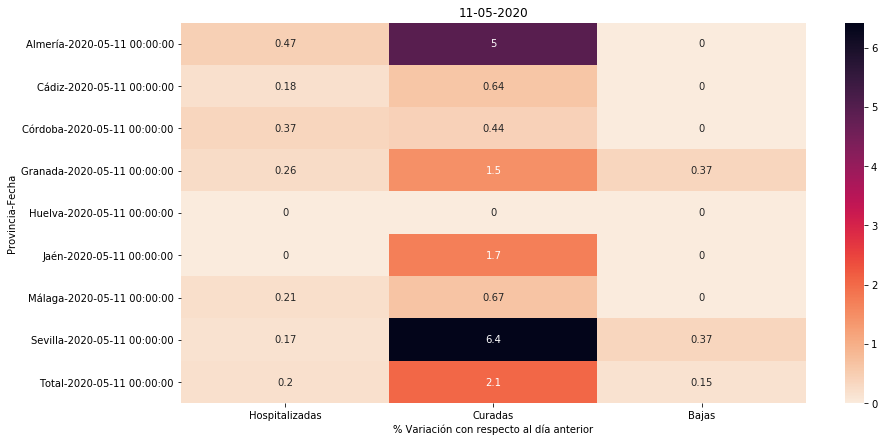

In [11]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG, annot=True, cmap=cmap)

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

In [12]:
provincia = 'Huelva'
dias = 15
data = df.loc[provincia][['Hospitalizadas', 'Curadas', 'Bajas']].diff().tail(dias).copy()
titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
# Correcciones
# El día 25/04/2020 el número de personas ingresadas calculado es negativo.
# Al ser datos acumulados lo que indica es una corrección en el número de ingresados acumulados a ese día
#data.loc['2020-04-25']['Hospitalizadas'] = 0

# El día 30/04/2020 aparecen 7 ingresos y los días anteriores y posteriores son 0 y -1
# Tiene pinta de ser un ajuste del cambio del día 25/04/2020
data.loc['2020-04-30']['Hospitalizadas'] = 0

# El día 01/05/2020 el número de personas ingresadas calculado es negativo.
# Al ser datos acumulados lo que indica es una corrección en el número de ingresados acumulados a ese día
data.loc['2020-05-01']['Hospitalizadas'] = 0

# El día 08/05/2020 el número de personas ingresadas calculado es negativo.
# Al ser datos acumulados lo que indica es una corrección en el número de ingresados acumulados a ese día
data.loc['2020-05-08']['Hospitalizadas'] = 0

In [13]:
print(titulo)
print(data)

Nuevos casos en los últimos 15 días en Huelva
            Hospitalizadas  Curadas  Bajas
Fecha                                     
2020-04-27             1.0      1.0    0.0
2020-04-28             3.0      1.0    0.0
2020-04-29             0.0      9.0    1.0
2020-04-30             0.0     20.0    2.0
2020-05-01             0.0     13.0    0.0
2020-05-02             0.0     14.0    0.0
2020-05-03             0.0      2.0    0.0
2020-05-04             0.0      7.0    0.0
2020-05-05             0.0      0.0    0.0
2020-05-06             0.0      7.0    1.0
2020-05-07             0.0     10.0    0.0
2020-05-08            -1.0     39.0    1.0
2020-05-09             0.0     21.0    1.0
2020-05-10             0.0      7.0    1.0
2020-05-11             0.0      0.0    0.0


Nuevos casos en los últimos 15 días en Huelva. (Nuevos ingresos hospitalarios)


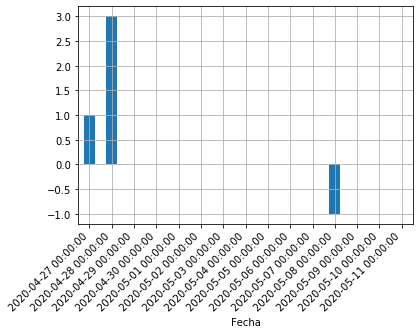

In [14]:
print(titulo + '. (Nuevos ingresos hospitalarios)')
data['Hospitalizadas'].plot(kind='bar', grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()